In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from chunked_dataset import ChunkedNPYDataset  
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random
from torchinfo import summary


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")


config = {
    'chunk_dir': './processed_chunks',
    'batch_size': 8,
    'learning_rate': 1e-4,
    'num_epochs': 50,
    'checkpoint_path': 'unet3d_checkpoint.pth',
    'best_model_path': 'best_unet3d_model.pth',
}


🖥️ Using device: cuda


In [ ]:

dataset = ChunkedNPYDataset(chunk_dir=config['chunk_dir'])
train_loader = DataLoader(
    dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print(f"✅ Loaded dataset with {len(dataset)} samples.")
sample = next(iter(train_loader))
print(f"📐 Batch sample shape: {sample['noisy'].shape} (should be [B, 1, 40, 64, 64])")



✅ Loaded dataset with 12000 samples.


/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../t

📐 Batch sample shape: torch.Size([8, 1, 40, 64, 64]) (should be [B, 1, 40, 64, 64])


In [ ]:

class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        super(UNet3D, self).__init__()

        features = init_features
        self.encoder1 = self._block(in_channels, features)
        self.pool1 = nn.MaxPool3d(kernel_size=2)

        self.encoder2 = self._block(features, features * 2)
        self.pool2 = nn.MaxPool3d(kernel_size=2)

        self.encoder3 = self._block(features * 2, features * 4)
        self.pool3 = nn.MaxPool3d(kernel_size=2)

        self.bottleneck = self._block(features * 4, features * 8)

        self.upconv3 = nn.ConvTranspose3d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = self._block(features * 8, features * 4)

        self.upconv2 = nn.ConvTranspose3d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = self._block(features * 4, features * 2)

        self.upconv1 = nn.ConvTranspose3d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = self._block(features * 2, features)

        self.output_conv = nn.Conv3d(features, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))

        bottleneck = self.bottleneck(self.pool3(enc3))

        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return self.output_conv(dec1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
        )


model = UNet3D(in_channels=1, out_channels=1).to(device)
print("✅ 3D U-Net model initialized and moved to device.")



summary(model, input_size=(8, 1, 40, 64, 64), col_names=["input_size", "output_size", "num_params", "kernel_size"])

✅ 3D U-Net model initialized and moved to device.


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
UNet3D                                   [8, 1, 40, 64, 64]        [8, 1, 40, 64, 64]        --                        --
├─Sequential: 1-1                        [8, 1, 40, 64, 64]        [8, 32, 40, 64, 64]       --                        --
│    └─Conv3d: 2-1                       [8, 1, 40, 64, 64]        [8, 32, 40, 64, 64]       896                       [3, 3, 3]
│    └─BatchNorm3d: 2-2                  [8, 32, 40, 64, 64]       [8, 32, 40, 64, 64]       64                        --
│    └─ReLU: 2-3                         [8, 32, 40, 64, 64]       [8, 32, 40, 64, 64]       --                        --
│    └─Conv3d: 2-4                       [8, 32, 40, 64, 64]       [8, 32, 40, 64, 64]       27,680                    [3, 3, 3]
│    └─BatchNorm3d: 2-5                  [8, 32, 40, 64, 64]       [8, 32, 40, 64, 64]       64                        --


In [ ]:

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5) 

In [ ]:

best_loss = float('inf')
loss_history = []

for epoch in range(config['num_epochs']):
    model.train()
    running_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{config['num_epochs']}]", leave=False)

    for batch in loop:
        noisy = batch['noisy'].to(device)  
        clean = batch['clean'].to(device)

        optimizer.zero_grad()
        output = model(noisy)              
        loss = criterion(output, clean)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * noisy.size(0)
        loop.set_postfix(loss=loss.item())

    scheduler.step()

    epoch_loss = running_loss / len(train_loader.dataset)
    loss_history.append(epoch_loss)

    print(f"📉 Epoch {epoch+1}: Avg Loss = {epoch_loss:.6f}")

    
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss,
    }, config['checkpoint_path'])

    
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), config['best_model_path'])
        print(f"✅ Best model updated at epoch {epoch+1} with loss {best_loss:.6f}")


Epoch [1/50]:   0%|                                    | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 1: Avg Loss = 0.002515
✅ Best model updated at epoch 1 with loss 0.002515


Epoch [2/50]:   0%|                                    | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 2: Avg Loss = 0.000396
✅ Best model updated at epoch 2 with loss 0.000396


Epoch [3/50]:   0%|                                    | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 3: Avg Loss = 0.000272
✅ Best model updated at epoch 3 with loss 0.000272


Epoch [4/50]:   0%|                                    | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 4: Avg Loss = 0.000199
✅ Best model updated at epoch 4 with loss 0.000199


Epoch [5/50]:   0%|                                    | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 5: Avg Loss = 0.000162
✅ Best model updated at epoch 5 with loss 0.000162


Epoch [6/50]:   0%|                                    | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 6: Avg Loss = 0.000141
✅ Best model updated at epoch 6 with loss 0.000141


Epoch [7/50]:   0%|                                    | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 7: Avg Loss = 0.000127
✅ Best model updated at epoch 7 with loss 0.000127


Epoch [8/50]:   0%|                                    | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 8: Avg Loss = 0.000112
✅ Best model updated at epoch 8 with loss 0.000112


Epoch [9/50]:   0%|                                    | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 9: Avg Loss = 0.000103
✅ Best model updated at epoch 9 with loss 0.000103


Epoch [10/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 10: Avg Loss = 0.000101
✅ Best model updated at epoch 10 with loss 0.000101


Epoch [11/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 11: Avg Loss = 0.000081
✅ Best model updated at epoch 11 with loss 0.000081


Epoch [12/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 12: Avg Loss = 0.000079
✅ Best model updated at epoch 12 with loss 0.000079


Epoch [13/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 13: Avg Loss = 0.000078
✅ Best model updated at epoch 13 with loss 0.000078


Epoch [14/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 14: Avg Loss = 0.000074
✅ Best model updated at epoch 14 with loss 0.000074


Epoch [15/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 15: Avg Loss = 0.000073
✅ Best model updated at epoch 15 with loss 0.000073


Epoch [16/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 16: Avg Loss = 0.000071
✅ Best model updated at epoch 16 with loss 0.000071


Epoch [17/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 17: Avg Loss = 0.000072


Epoch [18/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 18: Avg Loss = 0.000069
✅ Best model updated at epoch 18 with loss 0.000069


Epoch [19/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 19: Avg Loss = 0.000067
✅ Best model updated at epoch 19 with loss 0.000067


Epoch [20/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 20: Avg Loss = 0.000067


Epoch [21/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 21: Avg Loss = 0.000059
✅ Best model updated at epoch 21 with loss 0.000059


Epoch [22/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 22: Avg Loss = 0.000058
✅ Best model updated at epoch 22 with loss 0.000058


Epoch [23/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 23: Avg Loss = 0.000058


Epoch [24/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 24: Avg Loss = 0.000058
✅ Best model updated at epoch 24 with loss 0.000058


Epoch [25/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 25: Avg Loss = 0.000056
✅ Best model updated at epoch 25 with loss 0.000056


Epoch [26/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 26: Avg Loss = 0.000057


Epoch [27/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 27: Avg Loss = 0.000056
✅ Best model updated at epoch 27 with loss 0.000056


Epoch [28/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 28: Avg Loss = 0.000056


Epoch [29/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 29: Avg Loss = 0.000055
✅ Best model updated at epoch 29 with loss 0.000055


Epoch [30/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 30: Avg Loss = 0.000055
✅ Best model updated at epoch 30 with loss 0.000055


Epoch [31/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 31: Avg Loss = 0.000052
✅ Best model updated at epoch 31 with loss 0.000052


Epoch [32/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 32: Avg Loss = 0.000051
✅ Best model updated at epoch 32 with loss 0.000051


Epoch [33/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 33: Avg Loss = 0.000050
✅ Best model updated at epoch 33 with loss 0.000050


Epoch [34/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 34: Avg Loss = 0.000051


Epoch [35/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 35: Avg Loss = 0.000051


Epoch [36/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 36: Avg Loss = 0.000051


Epoch [37/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 37: Avg Loss = 0.000051


Epoch [38/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 38: Avg Loss = 0.000050
✅ Best model updated at epoch 38 with loss 0.000050


Epoch [39/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 39: Avg Loss = 0.000050


Epoch [40/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 40: Avg Loss = 0.000050
✅ Best model updated at epoch 40 with loss 0.000050


Epoch [41/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 41: Avg Loss = 0.000048
✅ Best model updated at epoch 41 with loss 0.000048


Epoch [42/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 42: Avg Loss = 0.000048
✅ Best model updated at epoch 42 with loss 0.000048


Epoch [43/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 43: Avg Loss = 0.000048


Epoch [44/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 44: Avg Loss = 0.000048


Epoch [45/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 45: Avg Loss = 0.000048


Epoch [46/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 46: Avg Loss = 0.000048


Epoch [47/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 47: Avg Loss = 0.000048
✅ Best model updated at epoch 47 with loss 0.000048


Epoch [48/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 48: Avg Loss = 0.000047
✅ Best model updated at epoch 48 with loss 0.000047


Epoch [49/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 49: Avg Loss = 0.000047


Epoch [50/50]:   0%|                                   | 0/1500 [00:00<?, ?it/s]/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  "clean": torch.from_numpy(clean).unsqueeze(0).float(),
/home/faisal/MLprojects/fMRI-LOADING/fMRI_dataloader/chunked_dataset.py:39: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warnin

📉 Epoch 50: Avg Loss = 0.000048


/tmp/ipykernel_98775/83459302.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(config['best_model_path'], map_location=device))
/tmp/ipyk

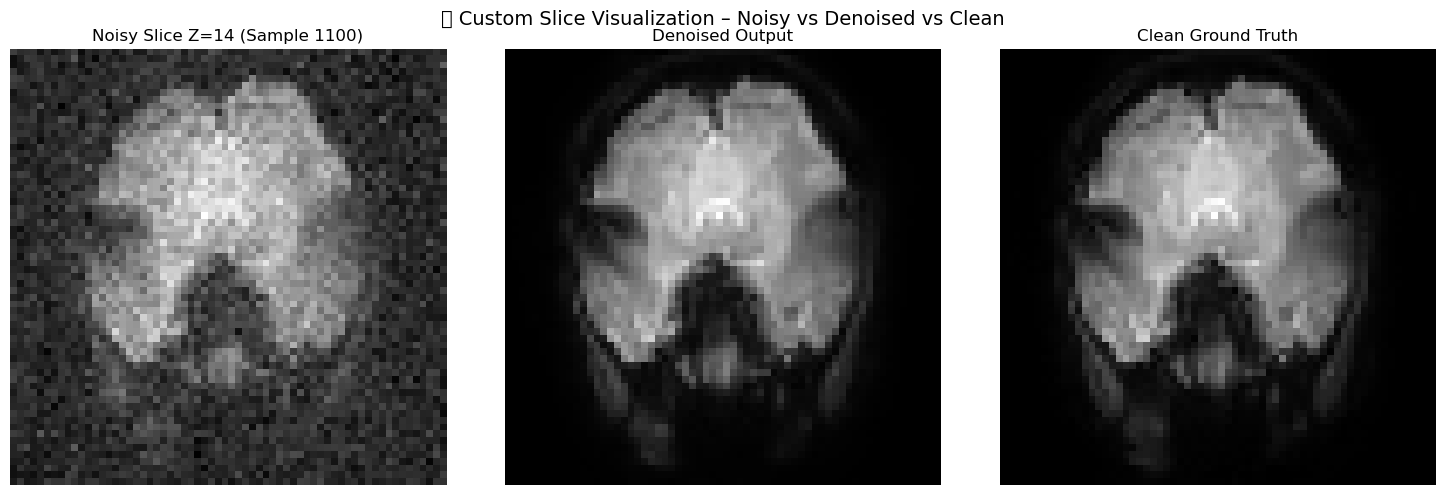

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from chunked_dataset import ChunkedNPYDataset

model.eval()
model.load_state_dict(torch.load(config['best_model_path'], map_location=device))
model.to(device)

dataset = ChunkedNPYDataset(config['chunk_dir'])


sample_index = 1100    
slice_index = 14  


sample = dataset[sample_index]

noisy_input = sample["noisy"].unsqueeze(0).to(device)     
clean_target = sample["clean"][0].cpu().numpy()          
noisy_input_np = sample["noisy"][0].cpu().numpy()      


with torch.no_grad():
    denoised_output = model(noisy_input)[0, 0].cpu().numpy()  


plt.figure(figsize=(15, 5))

# Noisy
plt.subplot(1, 3, 1)
plt.imshow(noisy_input_np[slice_index], cmap='gray')
plt.title(f"Noisy Slice Z={slice_index} (Sample {sample_index})")
plt.axis('off')

# Denoised
plt.subplot(1, 3, 2)
plt.imshow(denoised_output[slice_index], cmap='gray')
plt.title("Denoised Output")
plt.axis('off')

# Clean
plt.subplot(1, 3, 3)
plt.imshow(clean_target[slice_index], cmap='gray')
plt.title("Clean Ground Truth")
plt.axis('off')

plt.suptitle("Custom Slice Visualization – Noisy vs Denoised vs Clean", fontsize=14)
plt.tight_layout()
plt.show()


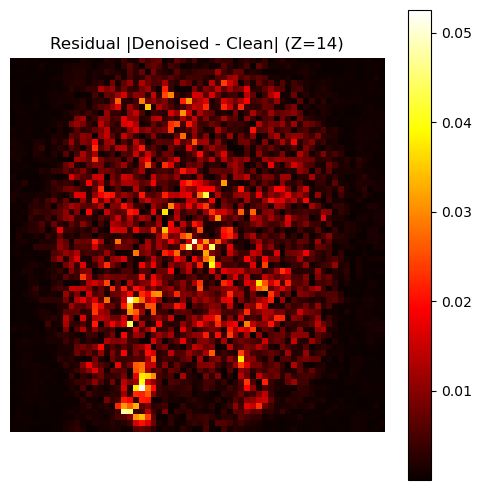

In [ ]:
# Visualize residual
diff = np.abs(denoised_output[slice_index] - clean_target[slice_index])

plt.figure(figsize=(5, 5))
plt.imshow(diff, cmap='hot')
plt.title(f"Residual |Denoised - Clean| (Z={slice_index})")
plt.axis('off')
plt.colorbar()
plt.tight_layout()
plt.show()


In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

def compute_metrics_single_sam(denoised_volume, clean_volume):
    
    psnr_list = []
    ssim_list = []

    for z in range(40):  
        psnr_val = psnr(clean_volume[z], denoised_volume[z], data_range=1.0)
        ssim_val = ssim(clean_volume[z], denoised_volume[z], data_range=1.0)
        psnr_list.append(psnr_val)
        ssim_list.append(ssim_val)

    avg_psnr = np.mean(psnr_list)
    avg_ssim = np.mean(ssim_list)

    print(f"📊 Sample PSNR (Z=0–39): {avg_psnr:.3f}")
    print(f"📊 Sample SSIM (Z=0–39): {avg_ssim:.3f}")
    
    return avg_psnr, avg_ssim


In [ ]:

sample = dataset[sample_index]
noisy_input = sample["noisy"].unsqueeze(0).to(device)
clean_volume = sample["clean"][0].cpu().numpy()               

with torch.no_grad():
    denoised_volume = model(noisy_input)[0, 0].cpu().numpy()  


avg_psnr, avg_ssim = compute_metrics_single_sam(denoised_volume, clean_volume)


📊 Sample PSNR (Z=0–39): 44.199
📊 Sample SSIM (Z=0–39): 0.990


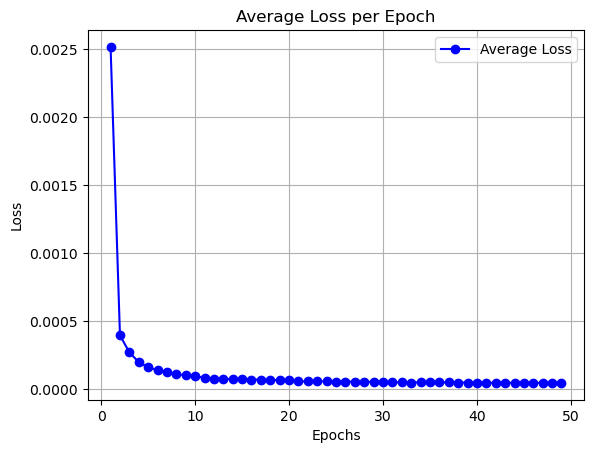

In [ ]:
import matplotlib.pyplot as plt


losses = [
    0.002515, 0.000396, 0.000272, 0.000199, 0.000162, 0.000141, 0.000127, 0.000112, 
    0.000103, 0.000101, 0.000081, 0.000079, 0.000078, 0.000074, 0.000073, 0.000071, 
    0.000072, 0.000069, 0.000067, 0.000067, 0.000059, 0.000058, 0.000058, 0.000058, 
    0.000056, 0.000057, 0.000056, 0.000056, 0.000055, 0.000055, 0.000052, 0.000051, 
    0.000050, 0.000051, 0.000051, 0.000051, 0.000051, 0.000050, 0.000050, 0.000050, 
    0.000048, 0.000048, 0.000048, 0.000048, 0.000048, 0.000048, 0.000048, 0.000047, 
    0.000047
]


epochs = list(range(1, len(losses) + 1))


plt.plot(epochs, losses, marker='o', color='b', label='Average Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Loss per Epoch')
plt.grid(True)
plt.legend()
plt.show()
